In [1]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import DataLoader

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from utils.dataset import DATASET_TEST

from _3rdparty.Binary_Segmentation_Evaluation_Tool.measures import *

In [5]:
# Configurations
# Please modify the value of "datset_paths" below with your own configuration
dataset_paths = {
    'ECSSD':     "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\ECSSD",
    'SOD':       "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\SOD",
    'PASCAL-S':  "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\PASCAL-S",
    'HKU-IS':    "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\HKU-IS",
    'DUT-OMRON': "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\DUT-OMRON",
    'DUTS-TE':   "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\DUTS-TE",
    'DUTS-TR':   "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\DUTS-TR",
}
weights_paths = {
    'DAANET_VGG16':                "./weights/daanet_vgg16_epochs_30.pdparam",
    'DAANET_VGG16_IOU':            "./weights/daanet_vgg16_iou_epochs_30.pdparam",
    'DAANET_VGG16_IOU_DAAM':       "./weights/daanet_vgg16_daam_iou_epochs_30.pdparam",
    'DAANET_VGG16_IOU_DAAM_BJD':   "./weights/daanet_vgg16_daam_bjd_iou_epochs_30.pdparam",
    'DAANET_RESNET50_IOU_DAAM':    "./weights/daanet_resnet50_daam_iou_epochs_25.pdparam",
    'DAANET_MOBILENETV2_IOU_DAAM': "./weights/daanet_mobilenet_v2_daam_iou_epochs_30.pdparam"
}
predictions_path = "./results/predictions"
curves_path = "./results/curves"
samples_path = "./samples"
# If you want to reproduce the comparision results in Figure. 2 and PR/F-measure curves results in Figure. 4
# please download the generated mask of previous papers through the instruction in README.md and modify the 
# value of "papers_mask_path"
papers_mask_path = "D:\\Workspace\\dataset\\Salient-Object-Detection-Datasets\\Papers-Pre-computed-Saiency-Map"


In [2]:
# Generate Prediction (function)
def generate_prediction(model, model_tag):
    for dt_name, path in dataset_paths.items():
        output_path = os.path.exists(os.path.join(predictions_path, dt_name, model_tag))
        if os.path.exists(output_path):
            continue
        else:
            os.makedirs(output_path)
        test_set = DATASET_TEST(path, dt_name, True)
        test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
        for img, gt, h, w, f_name in tqdm(test_loader()):
            pred = model(img)
            pred_arr = (F.sigmoid(pred[0]) * 255).reshape((256, 256)).numpy().astype('int')
            Image.fromarray(pred_arr).resize((w, h)).save(
                os.path.join(output_path, f_name.split(".")[0]+".png")
            )
        print("Prediction of {} generated!!".format(dt_name))

In [4]:
# Generate Prediction (DAANet-A)
# - FPN(VGG16)+DAAM+BGD+IOU
from models.daanet_daam_bjd_vgg16 import DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_VGG16_IOU_DAAM_BJD"]))
model.eval()

generate_prediction(model, "DAANet-A")

In [ ]:
# Generate Prediction (DAANet-B)
# - FPN(ResNet50)+DAAM+IOU
from models.daanet_daam_resnet50 import DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_RESNET50_IOU_DAAM"]))
model.eval()

generate_prediction(model, "DAANet-B")

In [ ]:
# Generate Prediction (DAANet-C)
# - FPN(MobileNetV2)+DAAM+IOU
from models.daanet_daam_mobilenet_v2 import DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_MOBILENETV2_IOU_DAAM"]))
model.eval()

generate_prediction(model, "DAANet-C")

In [ ]:
# Generate Prediction (for ablation study)
# - FPN(VGG16)
from models.pure.fpn_vgg16 import FPN as DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_VGG16"]))
model.eval()

generate_prediction(model, "DAANET_VGG16")

In [ ]:
# Generate Prediction (for ablation study)
# - FPN(VGG16)+IOU

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_VGG16_IOU"]))
model.eval()

generate_prediction(model, "DAANET_VGG16_IOU")

In [ ]:
# Generate Prediction (for ablation study)
# - FPN(VGG16)+DAAM+IOU
from models.daanet_daam_vgg16 import DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_VGG16_IOU_DAAM"]))
model.eval()

generate_prediction(model, "DAANET_VGG16_IOU_DAAM")

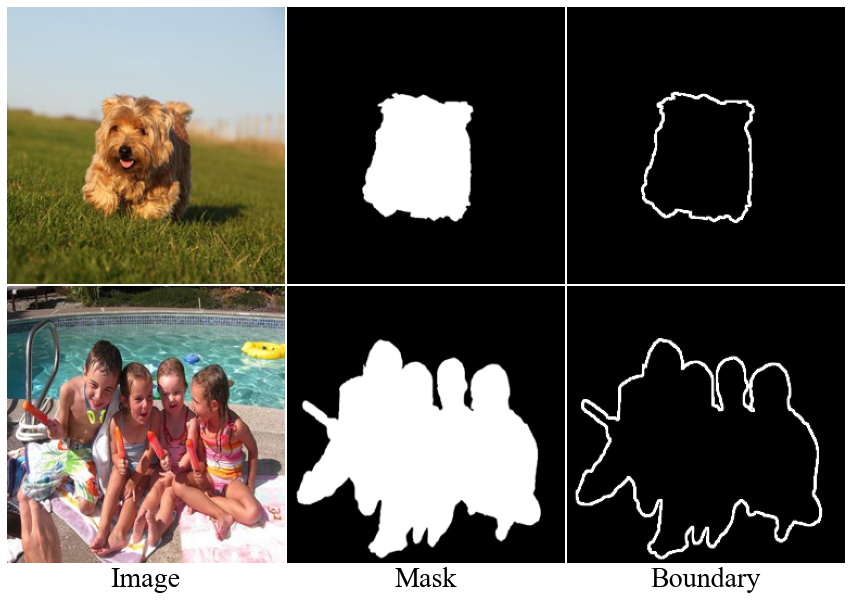

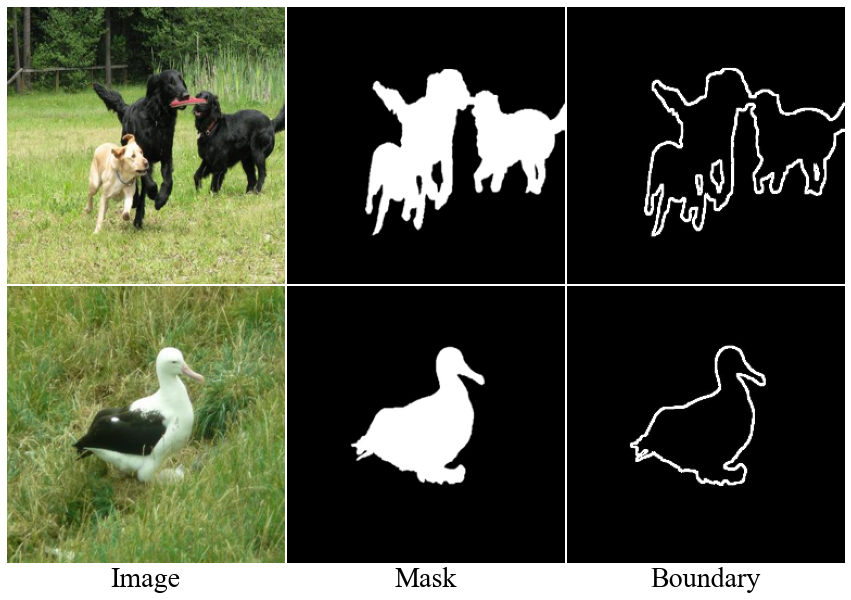

In [2]:
# Boundary and ground-truth samples
names = [
    [
        "ILSVRC2012_test_00000004",
        "ILSVRC2012_test_00000018"
    ], [
        "ILSVRC2012_test_00000172",
        "ILSVRC2012_test_00036309"
    ]
]

labels = ["Image", "Mask", "Boundary"]
font_dict = dict(
    fontsize=28, color='black',
    family='Times New Roman', weight='light')

for i, group in enumerate(names):
    fig = plt.figure(figsize=(15, 15))
    for j, name in enumerate(group):
        img = Image.open(os.path.join(samples_path, "img", name+".jpg")).resize((256, 256))
        mask = Image.open(os.path.join(samples_path, "gt", name+".png")).resize((256, 256))
        boundary = Image.open(os.path.join(samples_path, "bd", name+".png"))
        for k, item in enumerate([img, mask, boundary]):
            ax = plt.subplot(2, 3, j*3+k+1)
            if k != 0:
                plt.imshow(item, cmap="gray")
            else:
                plt.imshow(item)
            plt.xticks([])
            plt.yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if j == 1:
                plt.xlabel(labels[k], fontdict=font_dict)

    plt.subplots_adjust(wspace=0.01, hspace=-0.48)
    plt.savefig("./results/gt_{}.svg".format(i), bbox_inches='tight')


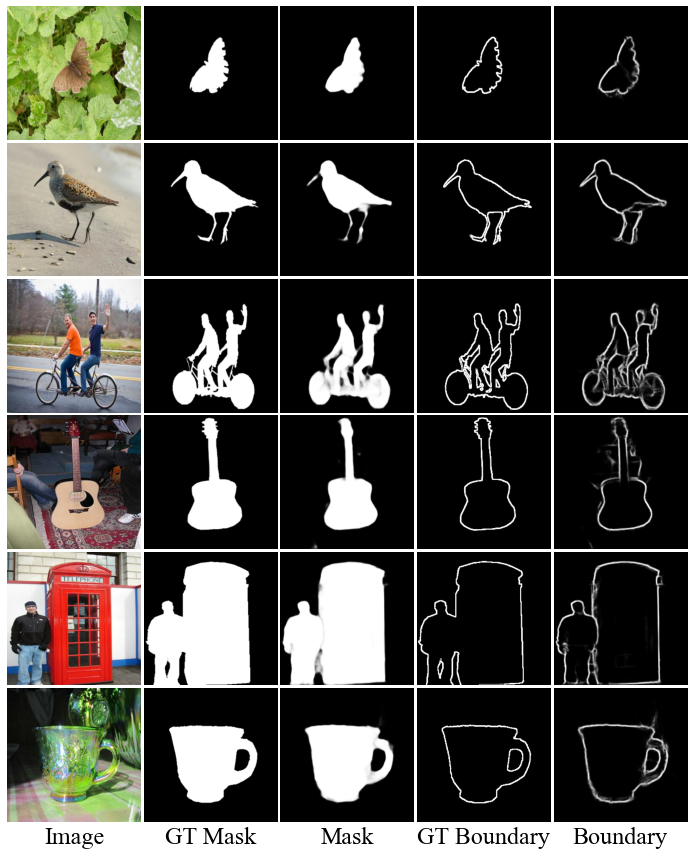

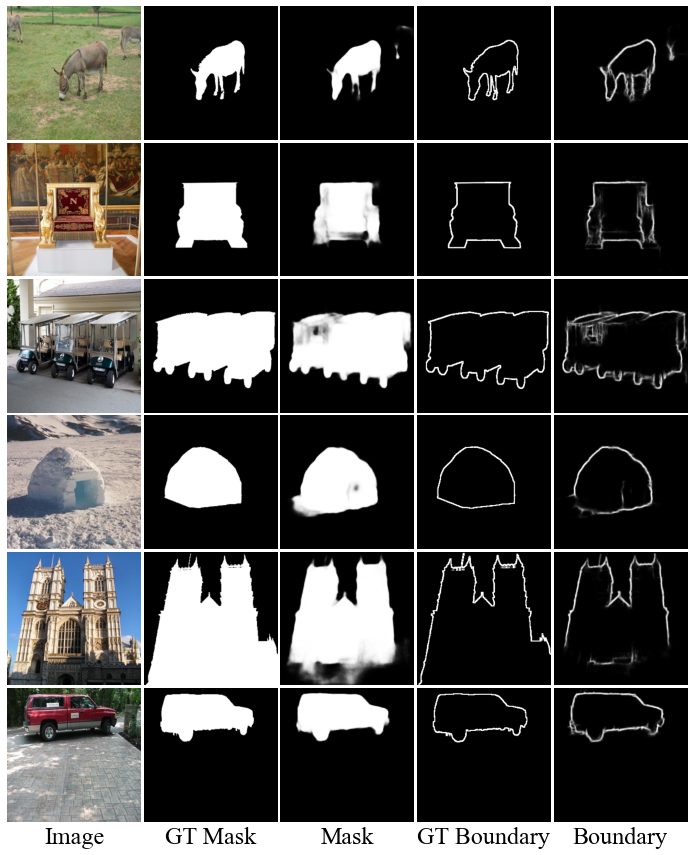

In [3]:
# Prediciton Sample Outputs
# - FPN(VGG16)+DAAM+BJD+IOU
from models.daanet_daam_bjd_vgg16 import DAANet

model = DAANet()
model.set_state_dict(paddle.load(weights_paths["DAANET_VGG16_IOU_DAAM_BJD"]))
model.eval()

names = [
    [
        "ILSVRC2012_test_00000025",
        "ILSVRC2012_test_00000776",
        "ILSVRC2012_test_00000649",
        "ILSVRC2012_test_00059263",
        "sun_bdugozwpdgupydsj",
        "ILSVRC2012_test_00079012"
    ], [
        "sun_bezaklalpcghwpjn",
        "ILSVRC2012_test_00074312",
        "ILSVRC2012_test_00055689",
        "sun_autbusnjxpbkrelv",
        "sun_auranzabcpbkjsji",
        "sun_auufeixuiinkshth"
    ]
]

labels = ["Image", "GT Mask", "Mask", "GT Boundary", "Boundary"]
font_dict = dict(
    fontsize=24, color='black',
    family='Times New Roman', weight='light')

for i, group in enumerate(names):
    fig = plt.figure(figsize=(15, 15))
    for j, name in enumerate(group):
        img = Image.open(os.path.join(samples_path, "img", name+".jpg")).resize((256, 256))
        gt_mask = Image.open(os.path.join(samples_path, "gt", name+".png")).resize((256, 256))
        gt_boundary = Image.open(os.path.join(samples_path, "gt", name+".png"))
        
        img_tensor = (paddle.to_tensor(np.array(img).transpose((2, 0, 1))/255) - 0.5)/0.5
        img_tensor = img_tensor.reshape((1, 3, 256, 256))
        pred = model(img_tensor.astype("float32"))
        pred_mask = (F.sigmoid(pred[0]) * 255).reshape((256, 256)).numpy().astype('int')
        pred_boundary = (F.sigmoid(pred[4]) * 255).reshape((256, 256)).numpy().astype('int')

        for k, item in enumerate([
                img, gt_mask, pred_mask, gt_boundary, pred_boundary]):
            ax = plt.subplot(6, 5, j*5+k+1)
            if k != 0:
                plt.imshow(item, cmap="gray")
            else:
                plt.imshow(item)
            plt.xticks([])
            plt.yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if j == 5:
                plt.xlabel(labels[k], fontdict=font_dict)

    plt.subplots_adjust(wspace=-0.53, hspace=0.02)
    plt.savefig("./results/res_{}.svg".format(i), bbox_inches='tight')

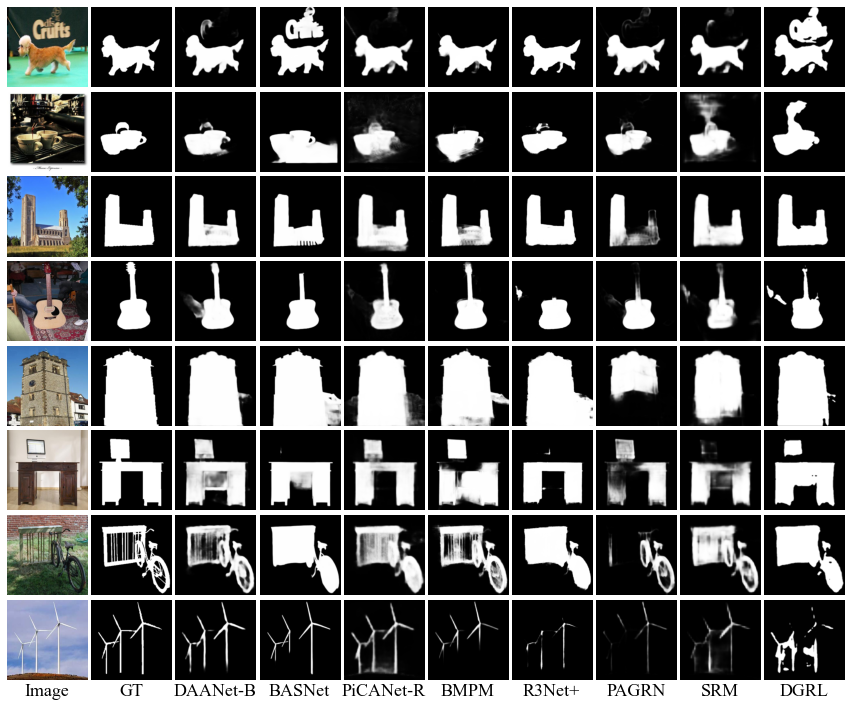

In [7]:
# Prediciton Sample Outputs Comparation
# - FPN(ResNet50)+DAAM+IOU
from models.daanet_daam_resnet50 import DAANet

model = DAANet(pretrained=False)
model.set_state_dict(weights_paths["DAANET_RESNET50_IOU_DAAM"])
model.eval()

ours_mask_path = "./results/predictions/DUTS-TE/DAANet-B"

names = [
    "ILSVRC2012_test_00000003",
    "ILSVRC2012_test_00000034",
    "sun_axrnvhwncmioyjat",
    "ILSVRC2012_test_00059263",
    "sun_acqhmwcuxygxhmhg",
    "sun_bpghpmbnlkuvhwrq",
    "sun_azkqgzlnnffuosai",
    "sun_bladhkujybiosxbx"
]

labels = [
    "Image", "GT", 
    "Ours-B", 
    "BASNet", "PiCANet-R", "BMPM", 
    "R3Net+", "PAGRN", "SRM", "DGRL"
]
font_dict = dict(
    fontsize=18, color='black',
    family='Times New Roman', weight='light')

fug = plt.figure(figsize=(15, 15))
for i, name in enumerate(names):
    img = Image.open(os.path.join(samples_path, "img", name+".jpg")).resize((256, 256))
    gt_mask = Image.open(os.path.join(samples_path, "gt", name+".png")).resize((256, 256))
    for j, label in enumerate(labels):
        ax = plt.subplot(8, 10, i*10+j+1)
        if label == "Image":
            plt.imshow(img)
        elif label == "GT":
            plt.imshow(gt_mask, cmap="gray")
        elif label == "Ours-B":
            ours_mask = Image.open(os.path.join(ours_mask_path, name+".png")).resize((256, 256))
            plt.imshow(ours_mask, cmap="gray")
        else:
            try:
                paper_mask = Image.open(os.path.join(papers_mask_path, "DUTS-TE", label, name+".png")).resize((256, 256))
            except:
                try:
                    paper_mask = Image.open(os.path.join(papers_mask_path, "DUTS-TE", label, name+".jpg")).resize((256, 256))
                except:
                    raise Exception("Error: file not found!!")            
            plt.imshow(paper_mask, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if i==7:
            plt.xlabel(labels[j] if labels[j]!= "Ours-B" else "DAANet-B", fontdict=font_dict)

plt.subplots_adjust(wspace=0.05, hspace=-0.62)
plt.savefig("./results/res_compare.pdf", bbox_inches='tight')

In [ ]:
# Generate PR/FM Curves (function)
import glob

folder_key = {
        'ECSSD': ['Imgs', 'Gt'], 'SOD': ['images', 'gt'],
        'PASCAL-S': ['Imgs', 'Gt'], 'HKU-IS': ['imgs', 'gt'],
        'DUT-OMRON': ['Imgs', 'Gt'], 'DUTS-TE': ['DUTS-TE-Image', 'DUTS-TE-Mask']
    }

def draw_pr_fm_curves(dt_name):
    data_name = dt_name 
    method_names = [
        "DSS+", "Amulet", "NLDF", "DGRL", "R3Net+", "BMPM",
        "DHS", "SRM", "PAGRN", "PiCANet-R", "ELD", "BASNet",
        "DAANet-A", "DAANet-B", "DAANet-C"
    ]
    lineSylClr = [
        "darkorange", "lime", "khaki", "black", "indigo", "cyan", 
        "pink", "deepskyblue", "violet", "deeppink", "chocolate", "brown", 
        "red", "purple", "blue"]
    linewidth = [
        1, 1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 1, 
        2, 2, 2]
    linestyles = [
        "--", "--", "--", "--", "--", "--", 
        "--", "--", "--", "--", "--", "--", 
        "-", "-", "-"]

    gt_name_list = glob.glob(dataset_paths[dt_name]+'/'+folder_key[dt_name][1]+"/"+'*.png') 

    ## get directory list of predicted maps
    rs_dir_lists = []
    for name in method_names:
        if "Ours" in name:
            rs_dir_lists.append(predictions_path+"/"+dt_name+'/'+name+"\\")
            continue
        rs_dir_lists.append(papers_mask_path+'/'+dt_name+"/"+name+"\\")

    PRE, REC, FM, gt2rs_fm = compute_PRE_REC_FM_of_methods(gt_name_list, rs_dir_lists, beta=0.3)
    plot_save_pr_curves(PRE, # numpy array (num_rs_dir,255), num_rs_dir curves will be drawn
                        REC, # numpy array (num_rs_dir,255)
                        method_names = method_names, # method names, shape (num_rs_dir), will be included in the figure legend
                        lineSylClr = lineSylClr, # curve colors, shape (num_rs_dir)
                        linewidth = linewidth, # curve width, shape (num_rs_dir)
                        linestyle = linestyles, # curve line style, shape (num_rs_dir)
                        xrange = (0.5,1.0), # the showing range of x-axis
                        yrange = (0.5,1.0), # the showing range of y-axis
                        dataset_name = data_name, # dataset name will be drawn on the bottom center position
                        save_dir = curves_path, # figure save directory
                        save_fmt = 'svg') # format of the to-be-saved figure

    plot_save_fm_curves(FM, # numpy array (num_rs_dir,255), num_rs_dir curves will be drawn
                        mybins = np.arange(0,256),
                        method_names = method_names, # method names, shape (num_rs_dir), will be included in the figure legend
                        lineSylClr = lineSylClr, # curve styles, shape (num_rs_dir)
                        linewidth = linewidth, # curve width, shape (num_rs_dir)
                        linestyle = linestyles, # curve line style, shape (num_rs_dir)
                        xrange = (0.0,1.0), # the showing range of x-axis
                        yrange = (0.0,1.0), # the showing range of y-axis
                        dataset_name = data_name, # dataset name will be drawn on the bottom center position
                        save_dir = curves_path, # figure save directory
                        save_fmt = 'svg') # format of the to-be-saved figure

In [ ]:
draw_pr_fm_curves("ECSSD")

In [ ]:
draw_pr_fm_curves("DUTS-TE")

In [ ]:
draw_pr_fm_curves("PASCAL-S")

In [ ]:
draw_pr_fm_curves("DUT-OMRON")

In [ ]:
draw_pr_fm_curves("HKU-IS")

In [ ]:
# Evaluate Model Size

from models.daanet_daam_bjd_vgg16 import DAANet as DAANet1
from models.daanet_daam_resnet50 import DAANet as DAANet2
from models.daanet_daam_mobilenet_v2 import DAANet as DAANet3

In [ ]:
# Evaluate DAANet-A
model = DAANet1(pretrained=False)
paddle.summary(model, input_size=(16, 3, 256, 256))

In [ ]:
# Evaluate DAANet-B
model = DAANet2(pretrained=False)
paddle.summary(model, input_size=(16, 3, 256, 256))

In [ ]:
# Evaluate DAANet-C
model = DAANet3(pretrained=False)
paddle.summary(model, input_size=(16, 3, 256, 256))